In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# 1. 读取数据集
try:
    df = pd.read_csv('flood_CHA.csv')
except FileNotFoundError:
    print("Error: flood_CHA.csv not found.")
    exit()

# 2. 提取关键数据并清洗
df_flood = df.copy()
df_flood = df_flood.dropna(subset=['Total Affected']).copy()
df_flood['Total Affected'] = df_flood['Total Affected'].astype(float)

# 转换为万人
df_flood['Total Affected'] = df_flood['Total Affected'] / 10000

# 过滤掉受灾人数为0的事件（如果您的关注点是大规模洪水事件）
df_flood = df_flood[df_flood['Total Affected'] > 0].copy()
data = df_flood['Total Affected'].values


成功加载文件: flood_CHA.csv

用于计算百分位数的正数据点数量: 263
筛选后数据的描述:
count    2.490000e+02
mean     1.970829e+06
std      4.897382e+06
min      7.000000e+00
25%      2.800000e+04
50%      1.500300e+05
75%      1.000000e+06
max      3.365203e+07
Name: Total Affected, dtype: float64

开始对筛选后的数据进行拟合...

拟合结果摘要:


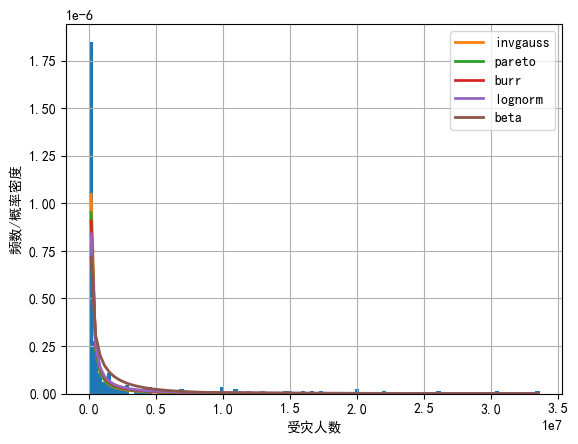


--- 对筛选后数据的拟合统计量 (按 sumsquare_error 升序排列) ---
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
invgauss     6.571763e-13  4028.484399  4039.036757     inf      0.119240   
pareto       8.213166e-13  3970.384185  3980.936544     inf      0.071082   
burr         9.004159e-13  3951.924148  3965.993959     inf      0.039946   
lognorm      1.033538e-12  3928.829889  3939.382248     inf      0.036342   
beta         1.317068e-12  4192.392964  4206.462776     inf      0.132552   

          ks_pvalue  
invgauss   0.001528  
pareto     0.153882  
burr       0.806542  
lognorm    0.885238  
beta       0.000282  

--- 对筛选后数据的最佳拟合分布 ---
按 sumsquare_error: {'invgauss': {'mu': 40.69159342764462, 'loc': -9650.015178366284, 'scale': 48670.47705134902}}
按 AIC: {'gamma': {'a': 0.43247661828589495, 'loc': 6.999999999999998, 'scale': 11280059.307566976}}
按 BIC: {'gamma': {'a': 0.43247661828589495, 'loc': 6.999999999999998, 'scale': 11280059.307566976}}

筛选后数据的最佳拟合分布 'invgau

In [2]:
# from fitter import Fitter, get_common_distributions, get_distributions
# distributions = ['invgauss','gamma', 'lognorm', 'beta', 'burr', 'norm', 'expon', 'weibull_min', 'pareto']
# f = Fitter(data,timeout=30)  # 设置超时时间，避免某些分布计算时间过长
# # 进行拟合
# f.fit()
# # 5. 查看拟合结果
# # 打印拟合结果的摘要
# print("\n拟合结果摘要:")
# f.summary()
# # 绘制拟合结果的可视化
# f.plot_pdf()
# plt.title("Fitted Distributions for 'Total Affected'")
# plt.xlabel("Total Affected (万)")
# plt.ylabel("Density")
# plt.show()
# # 6. 获取最佳拟合分布
# best_fit_name = list(f.get_best().keys())[0]
# print(f"\n最佳拟合分布: {best_fit_name}")
# # 获取最佳拟合分布的参数
# best_params = f.fitted_param[best_fit_name]
# print(f"参数: {best_params}")
# # 7. 可选：打印所有分布的拟合质量（按误差排序）
# print("\n所有分布拟合质量（按误差排序）:")
# print(f.df_errors.sort_values('sumsquare_error'))




import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

FILE_PATH = 'flood_CHA.csv'
COLUMN_TO_FIT = 'Total Affected'
PERCENTILE_THRESHOLD = 0.95


df = pd.read_csv(FILE_PATH)
print(f"成功加载文件: {FILE_PATH}")

data_series = df[COLUMN_TO_FIT].copy()
data_series_numeric = pd.to_numeric(data_series, errors='coerce')

nan_count = data_series_numeric.isnull().sum()
if nan_count > 0:
    data_series_numeric.dropna(inplace=True)

if data_series_numeric.empty:
    exit()

original_count = len(data_series_numeric)
data_positive = data_series_numeric[data_series_numeric > 0]
removed_zeros_negatives = original_count - len(data_positive)

if data_positive.empty:
   exit()

print(f"\n用于计算百分位数的正数据点数量: {len(data_positive)}")

if len(data_positive) < 2:
    data_to_fit = data_positive.copy()
else:
    cutoff_value = data_positive.quantile(PERCENTILE_THRESHOLD)
    data_to_fit = data_positive[data_positive <= cutoff_value].copy()
    num_removed_by_percentile = len(data_positive) - len(data_to_fit)

if data_to_fit.empty:
    exit()

print(f"筛选后数据的描述:\n{data_to_fit.describe()}")

# all_distributions = get_distributions()
all_distributions = ['invgauss','gamma', 'lognorm', 'beta', 'burr', 'norm', 'expon', 'weibull_min', 'pareto']
f_filtered = Fitter(data_to_fit,
                    distributions=all_distributions,
                    timeout=120)

print("\n开始对筛选后的数据进行拟合...")
try:
    f_filtered.fit()
except Exception as e:
    print(f"对筛选后数据进行拟合时发生错误: {e}")
    print("可能是由于数据特性或所选分布不适用。")
    exit()

print("\n拟合结果摘要:")
f_filtered.summary()
# 图像输出
summary_df_filtered = f_filtered.summary(plot=True)
plt.xlabel(f"受灾人数")
plt.ylabel("频数/概率密度")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.savefig('拟合结果.png',dpi=900)
plt.show()

print(f"\n--- 对筛选后数据的拟合统计量 (按 sumsquare_error 升序排列) ---")
print(summary_df_filtered)

print(f"\n--- 对筛选后数据的最佳拟合分布 ---")
best_fit_sse_filtered = f_filtered.get_best(method='sumsquare_error')
print(f"按 sumsquare_error: {best_fit_sse_filtered}")

try:
    best_fit_aic_filtered = f_filtered.get_best(method='aic')
    print(f"按 AIC: {best_fit_aic_filtered}")
except KeyError:
    print("警告: 无法基于 AIC 获取筛选后数据的最佳拟合。")

try:
    best_fit_bic_filtered = f_filtered.get_best(method='bic')
    print(f"按 BIC: {best_fit_bic_filtered}")
except KeyError:
    print("警告: 无法基于 BIC 获取筛选后数据的最佳拟合。")

if best_fit_sse_filtered:
    best_dist_name_filtered = list(best_fit_sse_filtered.keys())[0]
    best_params_filtered = best_fit_sse_filtered[best_dist_name_filtered]
    print(f"\n筛选后数据的最佳拟合分布 '{best_dist_name_filtered}' 的参数: {best_params_filtered}")


In [12]:
import numpy as np
from scipy.stats import beta
from scipy.optimize import curve_fit# 定义 Beta 分布的 PDF 函数（包含位置和尺度参数）
def beta_pdf(x, a, b, loc, scale):
    return beta.pdf(x, a, b, loc=loc, scale=scale)
# 获取直方图数据（用于拟合）
hist, bin_edges = np.histogram(data, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# 拟合 Beta 分布
params, _ = curve_fit(
    beta_pdf, 
    bin_centers, 
    hist, 
    p0=[0.3, 587, 0.0007, 339378]  # 使用 fitter 返回的初始参数
)
# 输出拟合参数
print("拟合参数 (a, b, loc, scale):", params)
# 计算理论 PDF 和直方图的平方偏差
predicted_pdf = beta_pdf(bin_centers, *params)
sse = np.sum((hist - predicted_pdf)**2)
print("平方偏差 (SSE):", sse)

拟合参数 (a, b, loc, scale): [ 9.35874786e+00  1.58885238e+05 -1.36184838e-01  7.62514344e+03]
平方偏差 (SSE): 43.07502070096552


In [16]:
import numpy as np
from scipy.stats import beta
# 使用 fitter 返回的参数
a, b, loc, scale = 0.3033, 587.9396, 0.0007, 339378.5966
# 生成理论 PDF（在数据范围内）
x = np.linspace(data.min(), data.max(), 1000)
theoretical_pdf = beta.pdf(x, a, b, loc=loc, scale=scale)
# 获取实际数据的直方图
hist, bin_edges = np.histogram(data, bins=1000, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# 计算平方偏差
predicted_pdf = beta.pdf(bin_centers, a, b, loc=loc, scale=scale)
sse = np.sum((hist - theoretical_pdf)**2)
print("平方偏差 (SSE):", sse)

平方偏差 (SSE): 20840.36429233756


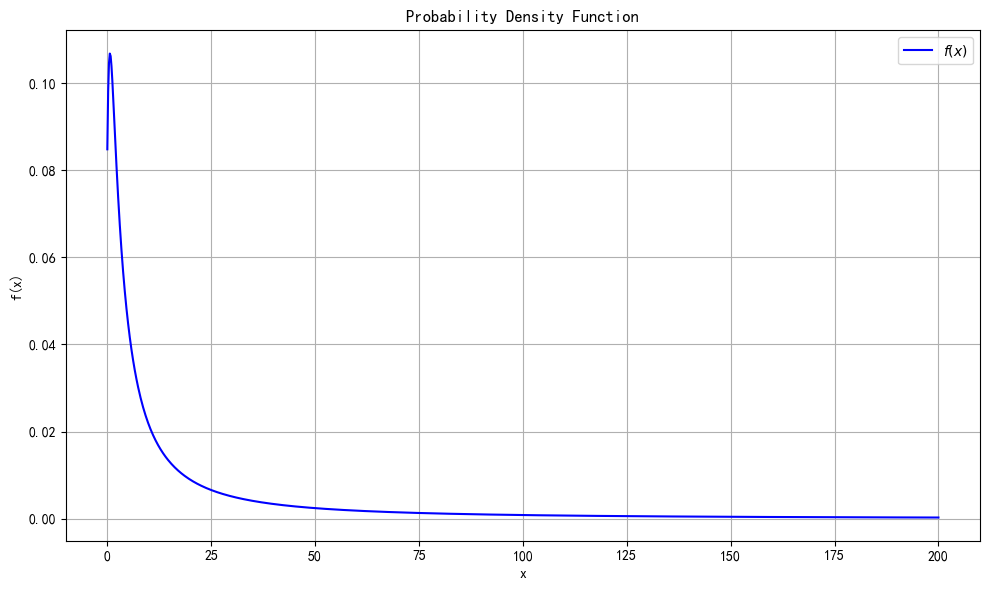

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 定义给定的概率密度函数
def f(x):
    A = 4.867045695125062
    mu = 40.691556848432256
    shift = 0.965000764762608
    denominator = (x + shift) ** 3
    exponent_numerator = A * ((x + shift) - mu) ** 2
    exponent_denominator = 2 * mu**2 * (x + shift)
    return np.sqrt(A / (2 * np.pi * denominator)) * np.exp(-exponent_numerator / exponent_denominator)

# 定义x的范围，避免x + shift为负或0
x = np.linspace(0.01, 200, 1000)
y = f(x)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=r'$f(x)$', color='blue')
plt.title('Probability Density Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
